In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame
from pandas_datareader import data, wb
from datetime import datetime

tf.set_random_seed(777)  # reproducibility


def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)



# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
predict_day = 5
learning_rate = 0.01
iterations = 500
LSTM_stack = 1


# Choose stock
stock = "KRX:005380"
pred_label = 3 # 0 : Open, 1: High 2: Low, 3:Close 4:Volumne

# data scrolling parts
# 날짜 지정
now=datetime.now()
year = now.year
month = now.month
day = now.day

start = datetime(2005, 1, 2)
end = datetime(year, month, day)
df = data.DataReader(
    stock,  # name
    "google",  # data source
    start,  # start
    end  # end
)



In [2]:

length=df.shape[0]
for i in range(1,predict_day+1):
    df.loc[length+i] = df.iloc[length-1]
    df.index.values[length+i-1]= datetime(year, month, day+i-1)
    

In [3]:
# Convert pandas dataframe to numpy array
dataset_temp = df.as_matrix()

# Open, High, Low, Volume, Close
test_min = np.min(dataset_temp, 0)
test_max = np.max(dataset_temp, 0)
test_denom = test_max - test_min

dataset = MinMaxScaler(dataset_temp)



In [4]:

dataset_temp = df.as_matrix()
test_last_X = (dataset_temp[-seq_length:,:]-test_min)/(test_denom+1e-7);



In [5]:
# build a dataset
dataX = []
dataY = []
dataY_temp = []
for i in range(0, len(dataset) - seq_length-predict_day+1):
    _x = dataset[i:i + seq_length]
    _y = dataset[i + predict_day:i + seq_length+predict_day]
    #print(i + seq_length+predict_day)
    dataX.append(_x)
    dataY.append(_y)
    

# train/test split 70 / 30
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])



In [6]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim], name='intput_X')
Y = tf.placeholder(tf.float32, [None, 1], name='intput_Y')

# build a LSTM network
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True) 
    return cell

multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(LSTM_stack)], state_is_tuple=True)


outputs_rnn, _states=tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)

In [7]:
X_for_fc = tf.reshape(outputs_rnn, [-1, hidden_dim])
Y_pred_temp = tf.contrib.layers.fully_connected(X_for_fc, output_dim, activation_fn=None)  
# reshape out for sequence_loss
Y_pred = tf.reshape(Y_pred_temp, [-1, seq_length])


In [8]:
# cost/loss
mean_loss = tf.reduce_sum(tf.square(Y_pred - Y), name='losses_sum')  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

trainY_label=trainY[:,[-1], pred_label]
testY_label=testY[:,[-1], pred_label]

In [9]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Tensorboard
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./tensorflowlog", sess.graph)
    
    losslist = [];
    # Training step
    for i in range(iterations):
    
        _, step_loss = sess.run([optimizer, mean_loss], 
                                        feed_dict={X: trainX, 
                                                   Y: trainY_label})
        losslist = np.append(losslist, step_loss)
        


    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    
    # Predictions test
    prediction_test = sess.run(Y_pred, feed_dict={X: test_last_X.reshape(1, seq_length, data_dim)})
   

In [10]:
print("predictions ", end='')
print(prediction_test *test_denom[pred_label]+test_min[pred_label])


predictions [[ 152531.59375   158385.015625  157178.78125   156135.6875    155318.34375
   154677.59375   154179.71875 ]]


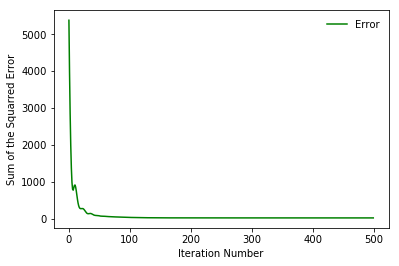

In [11]:
# Plot losss
plt.figure(1)
plt.plot(losslist, color="green", label="Error");
plt.xlabel("Iteration Number")
plt.ylabel("Sum of the Squarred Error")
plt.legend(loc='upper right', frameon=False)

plt.show()

In [13]:
predict_temp=(test_predict*test_denom[pred_label]+test_min[pred_label])
predict=np.empty((test_predict.shape[0]+seq_length-1 ,seq_length))
predict[:] = np.NAN
for i in range(0,seq_length):
    predict[i:test_predict.shape[0]+i,i]=predict_temp[:,i]
predict= DataFrame( predict.round())
#predict

In [14]:
Total_size=df.as_matrix().shape[0]
Predict_size=predict.shape[0]

predict_mean=predict.mean(axis =1)
Predict_close_concat=np.concatenate((np.zeros((Total_size-Predict_size,1))[:,-1],
                                     predict_mean), axis=0)



In [15]:
df["Predict Close"]=Predict_close_concat.round()

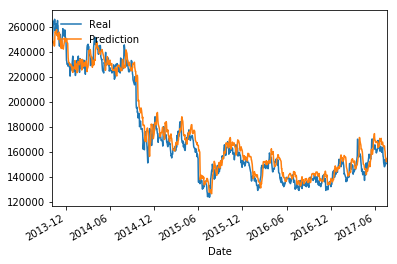

In [16]:
plt.figure(3)
df.iloc[Total_size-Predict_size:,3].plot(label="Real")
df.iloc[Total_size-Predict_size:,5].plot(label="Prediction")
plt.legend(loc='upper left', frameon=False)
plt.show()

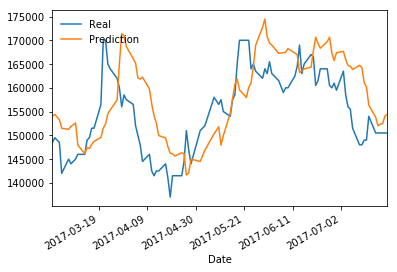

In [17]:
plt.figure(3)
df.iloc[-100:,3].plot(label="Real")
df.iloc[-100:,5].plot(label="Prediction")
plt.legend(loc='upper left', frameon=False)
plt.show()